The model predicts if the plate is dirty or clean from the photo. If the prediction probability of the class is higher than 0.5, then the plate is dirty, otherwise it is clean. The retrained Resnet network is used. A train dataset consists of a very small quantity of plate's photos and the model predicts probabilities for a very large number of the plate's photos.

In [ ]:
import torch
import numpy as np
import torchvision
import os
import matplotlib.pyplot as plt
import time 
import copy
import shutil
from tqdm  import tqdm
import pandas as pd
%matplotlib inline
import random
from torchvision import transforms, models

In [2]:
random.seed(77)
np.random.seed(77)
torch.manual_seed(77)
torch.cuda.manual_seed(77)
torch.backends.cudnn.deterministic = True

In [3]:
data_root = r"C:\Users\Denis\Documents\demo\Pytorch\kagle_pich\plates"
print(os.listdir(data_root))

['test', 'train']


In [4]:

train_dir = "train"
val_dir = "val"
class_names = ["cleaned","dirty"]
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name,class_name), exist_ok=True)
        

for class_name in class_names:
    source_dir = os.path.join(data_root,"train",class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 4 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir,class_name)
        shutil.copy(os.path.join(source_dir,file_name),os.path.join(dest_dir,file_name))

100%|██████████| 20/20 [00:00<00:00, 526.36it/s]


In [5]:

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224,scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomGrayscale(0.0001),
    transforms.RandomInvert(),
    transforms.RandomAutocontrast(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
    
])
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
])
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, train_transforms)

In [6]:
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)
val_dataloader = torch.utils.data.DataLoader(
val_dataset, batch_size = batch_size, shuffle = False, num_workers = 4)

In [7]:
len(train_dataloader), len(train_dataset)

(7, 52)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


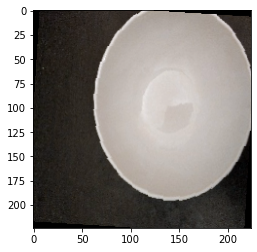

In [8]:
X_batch , y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1,2,0).numpy() * std + mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


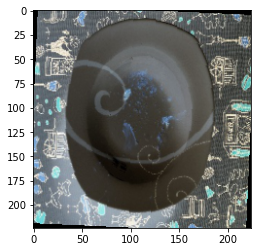

In [9]:
plt.imshow(X_batch[2].permute(1,2,0).numpy() * std + mean)

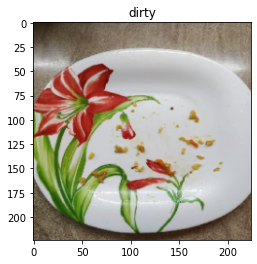

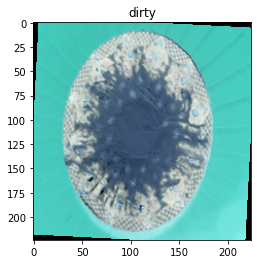

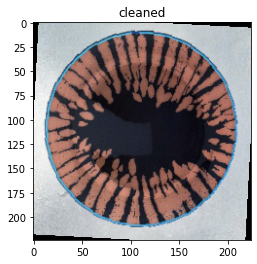

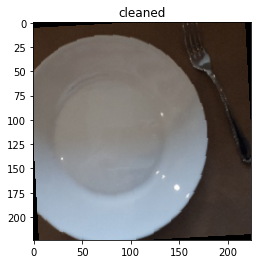

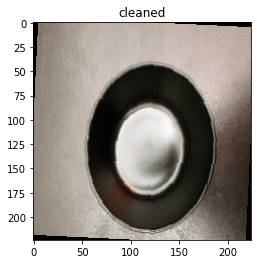

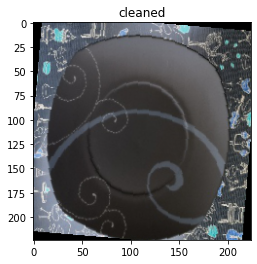

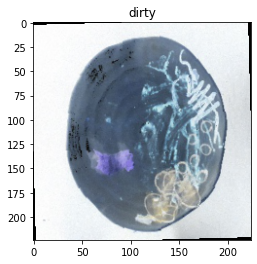

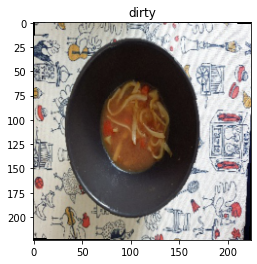

In [10]:
def show_input(input_tensor, title =""):
    image = input_tensor.permute(1,2,0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0,1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
X_batch, y_batch = next(iter(train_dataloader))
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title= class_names[y_item])

In [11]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs-1),flush= True)
        for phase in ["train","val"]:
            if phase == "train":
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()
            running_loss = 0.
            running_acc = 0.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == "train":
                        loss_value.backward()
                        optimizer.step()
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            print("{} loss : {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
    return model

In [12]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features,2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.001, amsgrad=True )

In [13]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma = 0.1)

In [14]:
num_epochs = 70

In [15]:
train_model(model, loss, optimizer, scheduler, num_epochs)

Epoch 0/69:


C:\Users\Denis\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\Denis\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|     

train loss : 0.6447 Acc: 0.6429


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]

val loss : 0.7474 Acc: 0.5625
Epoch 1/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.6558 Acc: 0.6607


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

val loss : 0.8113 Acc: 0.5000
Epoch 2/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.6540 Acc: 0.6964


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

val loss : 0.5471 Acc: 0.6875
Epoch 3/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.6051 Acc: 0.6429


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

val loss : 0.6395 Acc: 0.5000
Epoch 4/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.6045 Acc: 0.6786


100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

val loss : 0.7293 Acc: 0.5625
Epoch 5/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.5273 Acc: 0.7857


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.6193 Acc: 0.6042
Epoch 6/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4893 Acc: 0.8750


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.5737 Acc: 0.6250
Epoch 7/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3880 Acc: 0.8214


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.6882 Acc: 0.5625
Epoch 8/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4244 Acc: 0.8214


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.5749 Acc: 0.7500
Epoch 9/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4456 Acc: 0.8036


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.5485 Acc: 0.7292
Epoch 10/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4824 Acc: 0.7679


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]

val loss : 0.5151 Acc: 0.6250
Epoch 11/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.5124 Acc: 0.7143


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

val loss : 0.5694 Acc: 0.7917
Epoch 12/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3574 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.4844 Acc: 0.8542
Epoch 13/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3631 Acc: 0.9286


100%|██████████| 2/2 [00:03<00:00,  1.91s/it]

val loss : 0.5445 Acc: 0.8125
Epoch 14/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3249 Acc: 0.8929


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

val loss : 0.6047 Acc: 0.6250
Epoch 15/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3799 Acc: 0.8929


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.5883 Acc: 0.8125
Epoch 16/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3793 Acc: 0.8571


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.5843 Acc: 0.7500
Epoch 17/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3606 Acc: 0.8750


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]

val loss : 0.6413 Acc: 0.8125
Epoch 18/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3146 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.6192 Acc: 0.7292
Epoch 19/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3674 Acc: 0.8393


100%|██████████| 2/2 [00:03<00:00,  1.91s/it]

val loss : 0.5373 Acc: 0.8750
Epoch 20/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3165 Acc: 0.9643


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

val loss : 0.4999 Acc: 0.7917
Epoch 21/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2933 Acc: 0.9643


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.4705 Acc: 0.9375
Epoch 22/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4014 Acc: 0.7857


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.4636 Acc: 0.7500
Epoch 23/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3013 Acc: 0.8929


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

val loss : 0.5223 Acc: 0.8125
Epoch 24/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3189 Acc: 0.8750


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

val loss : 0.4824 Acc: 0.8750
Epoch 25/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3120 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

val loss : 0.5662 Acc: 0.8125
Epoch 26/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2932 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.4419 Acc: 0.8750
Epoch 27/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3329 Acc: 0.8393


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]

val loss : 0.5490 Acc: 0.6667
Epoch 28/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3394 Acc: 0.8929


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.5519 Acc: 0.7917
Epoch 29/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2824 Acc: 0.9286


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

val loss : 0.7068 Acc: 0.6667
Epoch 30/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2265 Acc: 0.9821


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

val loss : 0.5444 Acc: 0.7917
Epoch 31/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2844 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.4432 Acc: 0.8125
Epoch 32/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2463 Acc: 0.9286


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.5428 Acc: 0.6875
Epoch 33/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3217 Acc: 0.8929


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

val loss : 0.4646 Acc: 0.8125
Epoch 34/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3116 Acc: 0.8929


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]

val loss : 0.4184 Acc: 0.9375
Epoch 35/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3122 Acc: 0.9286


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.4086 Acc: 0.7917
Epoch 36/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3427 Acc: 0.8571


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

val loss : 0.5394 Acc: 0.7917
Epoch 37/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4212 Acc: 0.8571


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.3620 Acc: 0.9375
Epoch 38/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2793 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.5331 Acc: 0.8125
Epoch 39/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2637 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.3388 Acc: 0.9375
Epoch 40/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4020 Acc: 0.8214


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.4193 Acc: 0.8542
Epoch 41/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3879 Acc: 0.8214


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.6403 Acc: 0.6667
Epoch 42/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2755 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]

val loss : 0.3466 Acc: 0.9375
Epoch 43/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2766 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

val loss : 0.4271 Acc: 0.9375
Epoch 44/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2545 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

val loss : 0.4914 Acc: 0.7917
Epoch 45/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2907 Acc: 0.9286


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.5850 Acc: 0.8750
Epoch 46/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2434 Acc: 0.9821


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.5651 Acc: 0.7292
Epoch 47/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2127 Acc: 0.9821


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

val loss : 0.4558 Acc: 0.8750
Epoch 48/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3228 Acc: 0.8750


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

val loss : 0.5676 Acc: 0.8750
Epoch 49/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3087 Acc: 0.9286


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

val loss : 0.5210 Acc: 0.8750
Epoch 50/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2473 Acc: 0.9464


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

val loss : 0.7118 Acc: 0.7500
Epoch 51/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3107 Acc: 0.8750


100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

val loss : 0.5053 Acc: 0.8125
Epoch 52/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2572 Acc: 0.9643


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

val loss : 0.5032 Acc: 0.7500
Epoch 53/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3408 Acc: 0.8929


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

val loss : 0.5294 Acc: 0.7500
Epoch 54/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2627 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  2.00s/it]

val loss : 0.4788 Acc: 0.8750
Epoch 55/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2434 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.5859 Acc: 0.8125
Epoch 56/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4854 Acc: 0.7321


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.3437 Acc: 0.8750
Epoch 57/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.4016 Acc: 0.8393


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.6637 Acc: 0.8125
Epoch 58/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2794 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

val loss : 0.3660 Acc: 0.8542
Epoch 59/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2936 Acc: 0.9643


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.4364 Acc: 0.8125
Epoch 60/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3776 Acc: 0.8750


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.4317 Acc: 0.7917
Epoch 61/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3087 Acc: 0.8393


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]

val loss : 0.4252 Acc: 0.7500
Epoch 62/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2727 Acc: 0.9464


100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

val loss : 0.6410 Acc: 0.8750
Epoch 63/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2905 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.4992 Acc: 0.6875
Epoch 64/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2779 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val loss : 0.5671 Acc: 0.7292
Epoch 65/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3128 Acc: 0.8571


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.5900 Acc: 0.7500
Epoch 66/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2336 Acc: 0.9643


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

val loss : 0.4467 Acc: 0.8125
Epoch 67/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2828 Acc: 0.8750


100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

val loss : 0.4318 Acc: 0.8125
Epoch 68/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.3850 Acc: 0.8393


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.3329 Acc: 0.8125
Epoch 69/69:



  0%|          | 0/2 [00:00<?, ?it/s]

train loss : 0.2972 Acc: 0.9107


100%|██████████| 2/2 [00:03<00:00,  1.95s/it]

val loss : 0.5424 Acc: 0.7917


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
test_dir = "test"
shutil.copytree(os.path.join(data_root,"test"),
               os.path.join(test_dir),"unknown")

'test'

In [17]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
])

In [18]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
test_dataset = ImageFolderWithPaths(test_dir, test_transforms)
test_dataloader = torch.utils.data.DataLoader(
test_dataset, batch_size=30, shuffle=False)

In [19]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
model.eval()
test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
    torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
test_predictions = np.concatenate(test_predictions)

100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


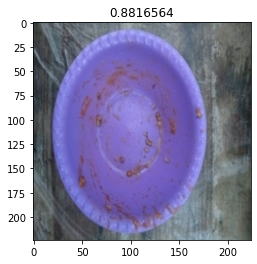

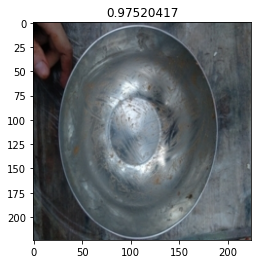

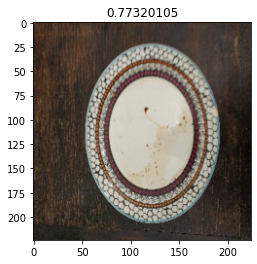

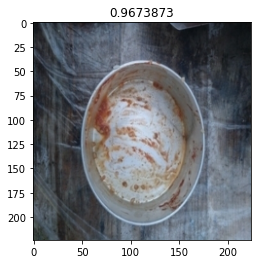

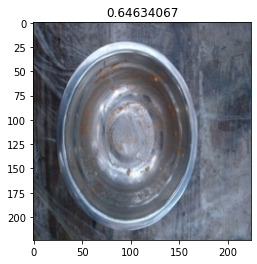

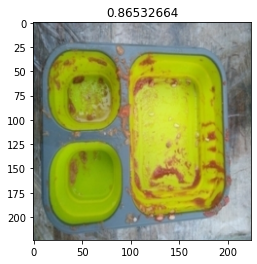

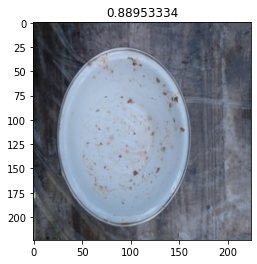

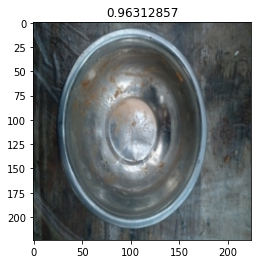

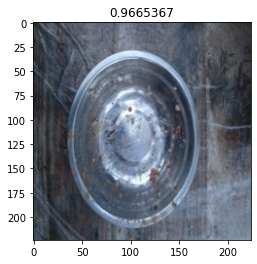

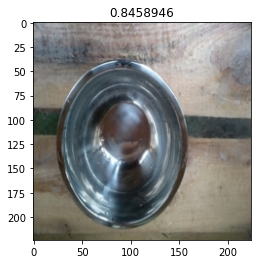

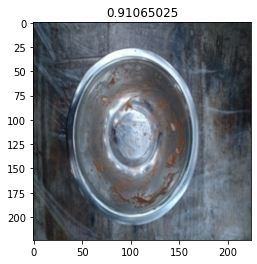

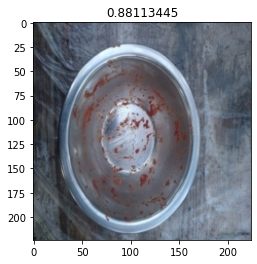

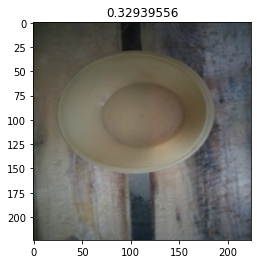

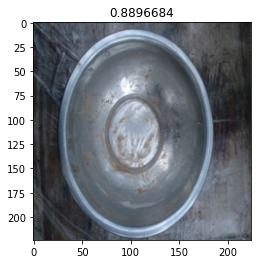

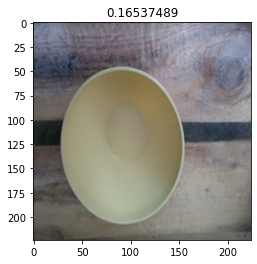

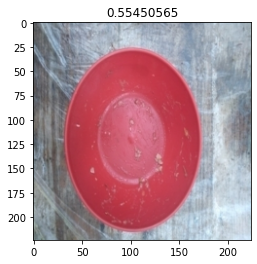

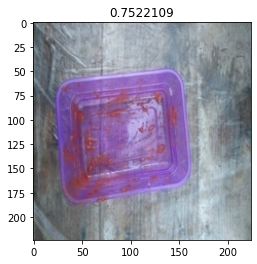

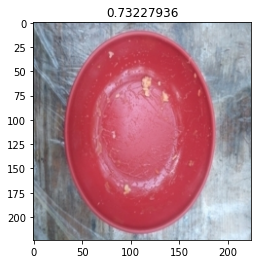

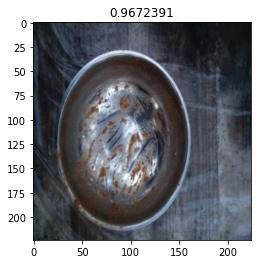

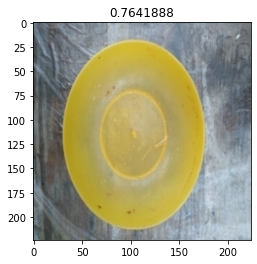

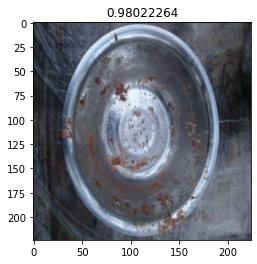

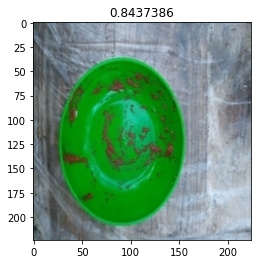

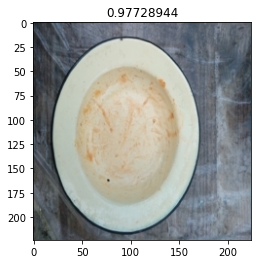

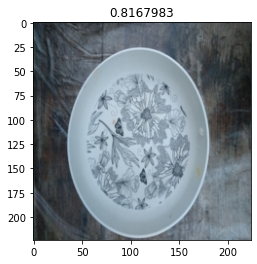

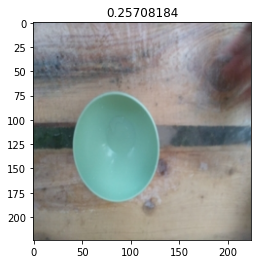

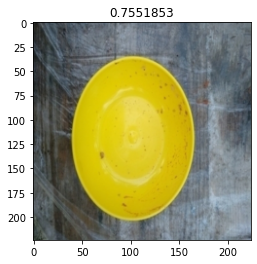

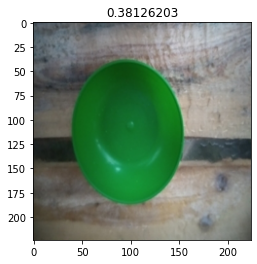

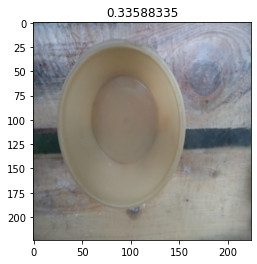

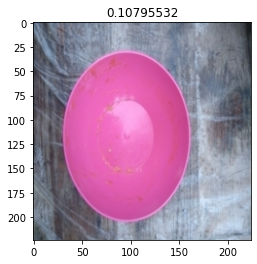

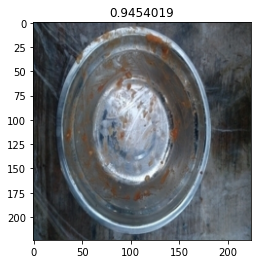

In [21]:
inputs, labels, paths = next(iter(test_dataloader))
for img, pred in zip(inputs , test_predictions):
    show_input(img, title = pred)


In [22]:
submission_df  = pd.DataFrame.from_dict({"id" : test_img_paths, "label" : test_predictions})


In [23]:
submission_df

id     label
0    test\.ipynb_checkpoints\0000.jpg  0.881656
1    test\.ipynb_checkpoints\0001.jpg  0.975204
2    test\.ipynb_checkpoints\0002.jpg  0.773201
3    test\.ipynb_checkpoints\0003.jpg  0.967387
4    test\.ipynb_checkpoints\0004.jpg  0.646341
..                                ...       ...
739  test\.ipynb_checkpoints\0739.jpg  0.842420
740  test\.ipynb_checkpoints\0740.jpg  0.948405
741  test\.ipynb_checkpoints\0741.jpg  0.031885
742  test\.ipynb_checkpoints\0742.jpg  0.758799
743  test\.ipynb_checkpoints\0743.jpg  0.241180

[744 rows x 2 columns]

In [24]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str[25:28]
submission_df['id'] = submission_df['id'].astype(int)
submission_df.set_index('id', inplace=True)
submission_df

label
id          
0      dirty
1      dirty
2      dirty
3      dirty
4      dirty
..       ...
739    dirty
740    dirty
741  cleaned
742    dirty
743  cleaned

[744 rows x 1 columns]